In [214]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [215]:
# 2
# Load data and look at dimensionality
data = np.loadtxt("EMG_data_for_gestures-master/01/1_raw_data_13-12_22.03.16.txt", skiprows=1)
data2 = np.loadtxt("EMG_data_for_gestures-master/01/2_raw_data_13-13_22.03.16.txt", skiprows=1)
shape = data.shape
print(shape)

(63196, 10)


Text(0.5,0,'Time Sample')

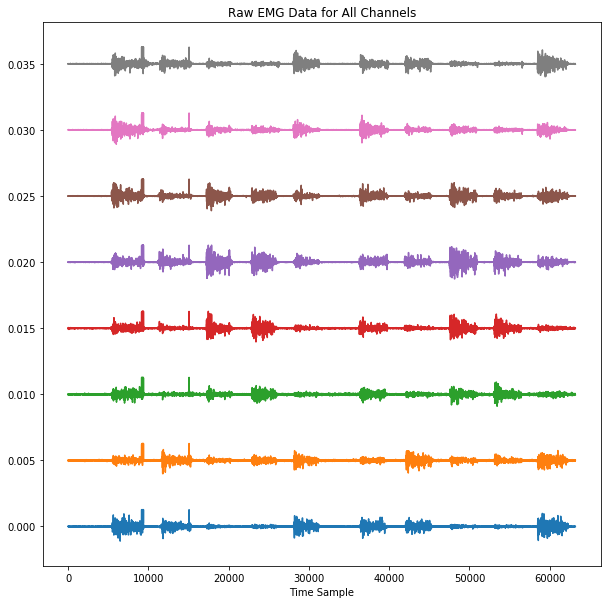

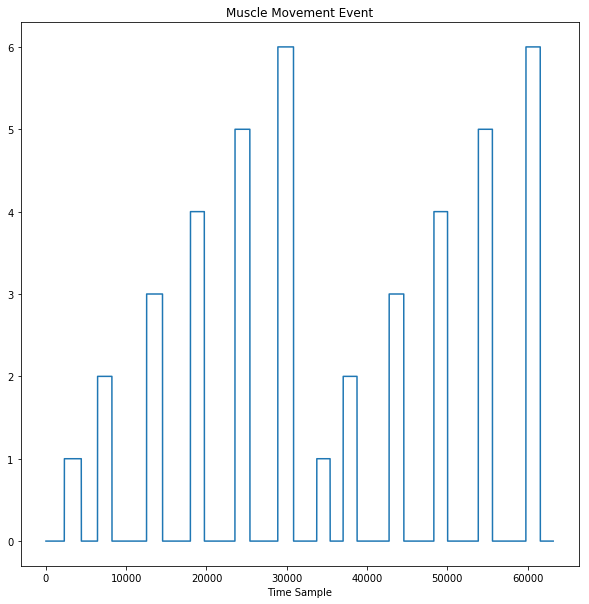

In [216]:
# Plot all 8 channels to visualize the data
offset = np.zeros((8))
for i in range(8):
    offset[i] = i*0.005
    
plt.figure(figsize=(10,10))
plt.plot(data[:, 1:9]+offset.T)
plt.title("Raw EMG Data for All Channels")
plt.xlabel("Time Sample")

# Looking at when each gesture occurs
plt.figure(figsize=(10,10))
plt.plot(data[:, -1])
plt.title("Muscle Movement Event")
plt.xlabel("Time Sample")

# Each gesture is done twice and there are six gestures
# This is a bit tricky since it's time series data, but a multiclass classification task

In [217]:
# 2
# I'll start by doing simple logistic regression on the raw data where the input 
# is a single time point with the features being the 8 channels
X = np.concatenate((data[:, 1:9], data2[:, 1:9]), axis=0)
X = X - np.mean(X, axis=0)
X = X / np.linalg.norm(X, axis=0)

# I mean subtracted and normalized so we don't have to worry about bias 
# and differences in amplitude between channels and recordings
y = np.concatenate((data[:, -1], data2[:, -1]), axis=0)

# Fit model using a multi class classifier
model = LogisticRegression(solver='lbfgs', multi_class='auto').fit(X, y)

# Poor Accuracy
print("Training Accuracy: ", model.score(X, y))

# Use a confusion matrix to see whats happening
predictions = model.predict(X)
confusion_matrix = metrics.confusion_matrix(y, predictions)
print(confusion_matrix)

# So we saw this in the earlier plot that the data is predominately class 0 so it dominates the classification task

Training Accuracy:  0.6493521498720806
[[78682     0     0     0     0     0     0]
 [ 7311     0     0     0     0     0     0]
 [ 6806     0     0     0     0     0     0]
 [ 7329     0     0     0     0     0     0]
 [ 6824     0     0     0     0     0     0]
 [ 7075     0     0     0     0     0     0]
 [ 7143     0     0     0     0     0     0]]


In [218]:
# I am going to process the data so that all data for each gesture is together
m0 = X[np.where(y == 0), :]
print("Number of samples in class 0: ", m0.shape[1])
m1 = X[np.where(y == 1), :]
print("Number of samples in class 1: ", m1.shape[1])
m2 = X[np.where(y == 2), :]
print("Number of samples in class 2: ", m2.shape[1])
m3 = X[np.where(y == 3), :]
print("Number of samples in class 3: ", m3.shape[1])
m4 = X[np.where(y == 4), :]
print("Number of samples in class 4: ", m4.shape[1])
m5 = X[np.where(y == 5), :]
print("Number of samples in class 5: ", m5.shape[1])
m6 = X[np.where(y == 6), :]
print("Number of samples in class 6: ", m6.shape[1])

# From the documentation we see that 0 is just unmarked data therefore we should not use any of it in the model
# We see that for labels 1-6 the classes are pretty balanced so all we need to do is discard m0

X_rebalanced = np.squeeze(np.concatenate((m1, m2, m3, m4, m5, m6), axis=1))
y_rebalanced = np.squeeze(np.concatenate((y[np.where(y == 1)], y[np.where(y == 2)], y[np.where(y == 3)], y[np.where(y == 4)], y[np.where(y == 5)], y[np.where(y == 6)])))

model_rebalanced = LogisticRegression(solver='lbfgs', multi_class='auto').fit(X_rebalanced, y_rebalanced)
# Still quite poor Accuracy
print(model_rebalanced.score(X_rebalanced, y_rebalanced))

# Use a confusion matrix to see whats happening
predictions = model_rebalanced.predict(X_rebalanced)
confusion_matrix = metrics.confusion_matrix(y_rebalanced, predictions)
print(confusion_matrix)
# At least we get some value on the diagonal meaning we aren't just classifying everything as one class, but still very bad.

Number of samples in class 0:  78682
Number of samples in class 1:  7311
Number of samples in class 2:  6806
Number of samples in class 3:  7329
Number of samples in class 4:  6824
Number of samples in class 5:  7075
Number of samples in class 6:  7143
0.1386509131990209
[[  29    0 7282    0    0    0]
 [1847    0 4910    0    0   49]
 [1746    0 5583    0    0    0]
 [1760    0 4720  279    0   65]
 [2256    0 4760    9    0   50]
 [ 995    0 6148    0    0    0]]


Text(0.5,1,'Data Points Projected into PCA Space')

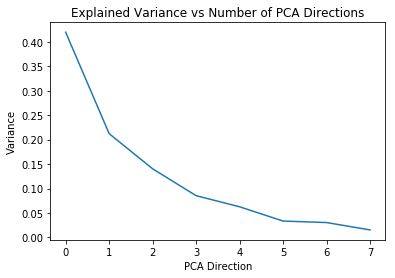

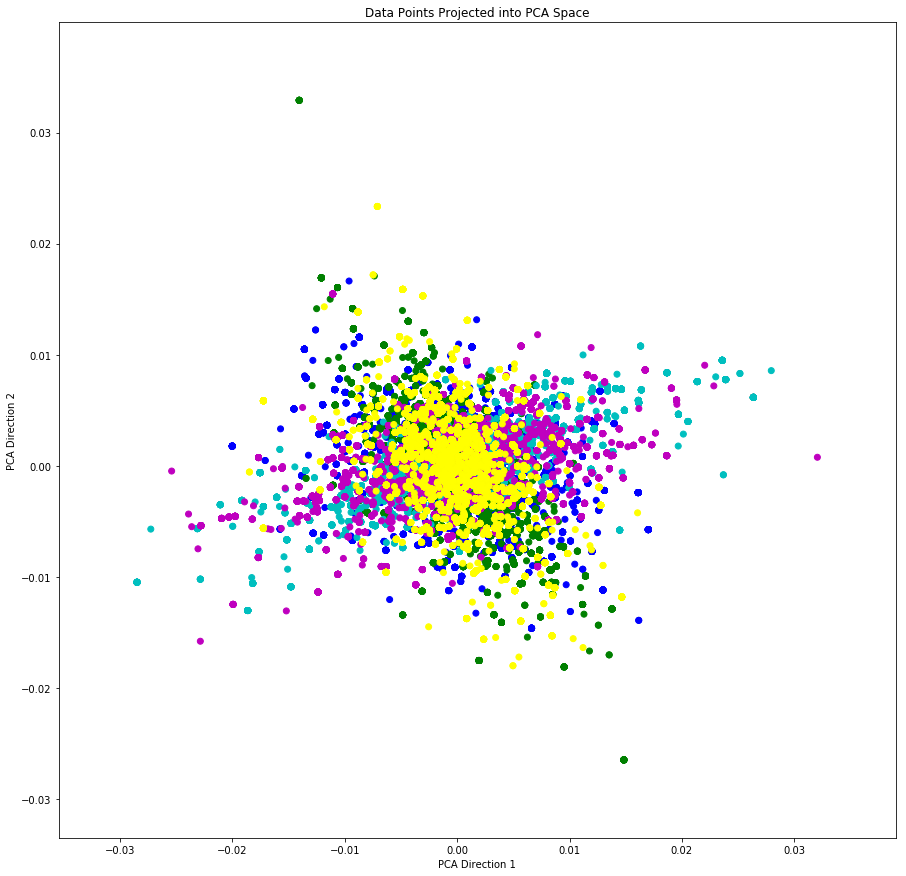

In [219]:
pca = PCA(n_components=8)
pca.fit(X_rebalanced)
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained Variance vs Number of PCA Directions")
plt.xlabel("PCA Direction")
plt.ylabel("Variance")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_rebalanced)
colors = ['r', 'b', 'g', 'c', 'm', 'yellow']
c = []
for i in range(y_rebalanced.shape[0]):
    c.append(colors[int(y_rebalanced[i]-1)])
plt.figure(figsize=(15, 15))
plt.scatter(X_pca[:, 0], X_pca[:, 1], color=c)
plt.xlabel("PCA Direction 1")
plt.ylabel("PCA Direction 2")
plt.title("Data Points Projected into PCA Space")
# I projected the data into PCA space to visualize it
# We can see that the data highly overlaps, meaning using a classifier to 
# discriminate the data in this form is a futile task.
# Thus logistic regression is not the right method for this.
# Also since we are dealing with time series, it is not a good idea to use individual time points as data 
# since you expect the discriminatory features to exist over a span of time. 
# Logisitic regression could perform much better if I used some high level features of the data to classify,
# such as average power or something like it.

(8317, 30, 8)
(8317,)


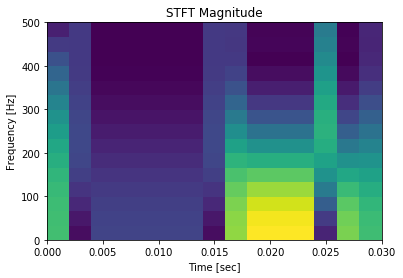

In [232]:
import math
import scipy.signal as signal
import copy
# Alternative method
# I want to leverage the temporal aspects of the data more and use a state of the art classifier
# I will use a CNN on the data in the time domain and the time frequency domain.
# I could have also used some classic ML classifiers like SVM's, LDA, Random Forest, etc but that requires me to 
# know the relevant features to extract from the data, which I dont since I am not a domain expert.
# A CNN will probably outperform these methods and I will need to do minimal feature engineering.

# First Step: preprocess data
# I have already split the data into each specific gesture so now i will sample from those waveforms.
# I could use the whole recording as a single data point, but to use a CNN I need more data and the data doesn't
# Need to be iid (data augmentation)

# Sampling rate
fs = 1000
# Define the window length of data we are selecting
window_length = 30
# I'm going to extract overlapping blocks and I will increment by step 
step = 5

# iterate over the gestures
all_time_data = []
time_lengths = []
y_time = []
for idx, gesture in enumerate([m1, m2, m3, m4, m5, m6]):
    gesture = np.squeeze(gesture)
    # Define the time length since each gesture has a different number of time samples
    time_length = gesture.shape[0]
    time_lengths.append(time_length)
    # Find the number of windows we will take given our window length and step
    num_data = math.floor((time_length - window_length) / step)
    # Now extract the windows
    time_data = np.zeros((num_data, window_length, 8))
    for n in range(num_data):
        time_data[n, :, :] = gesture[n*step:n*step+window_length, :]
        y_time.append(idx+1)
    all_time_data.append(time_data)

# Done with time domain data
X_time_train = np.concatenate((all_time_data[0], all_time_data[1], all_time_data[2], all_time_data[3], all_time_data[4], all_time_data[5]), axis=0)
y_time_train = np.array(y_time) - 1
print(X_time_train.shape)
print(y_time_train.shape)

# Did some tuning of the size of the stft
f, t, Zxx = signal.stft(X_time_train[50, :, 0], fs, nperseg=5, noverlap=3, nfft=30)
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()   

# Generate stft data from time data
X_stft_train = np.zeros((X_time_train.shape[0], 16, 16, 8))
for i in range(X_time_train.shape[0]):
    for j in range(X_time_train.shape[2]):
        f, t, Zxx = signal.stft(X_time_train[i, :, j], fs, nperseg=5, noverlap=3, nfft=30)
        X_stft_train[i, :, :, j] = np.asarray(np.abs(Zxx))

y_stft_train = copy.deepcopy(y_time_train)
# y_stft_train = np.zeros((X_stft_train.shape[0], 6))
# for i in range(X_stft_train.shape[0]):
#     y_stft_train[i, y_time_train-1] = 1

(136426, 10)
Number of samples in class 1:  7140
Number of samples in class 2:  6777
Number of samples in class 3:  6815
Number of samples in class 4:  6812
Number of samples in class 5:  6856
Number of samples in class 6:  7372
(8317, 30, 8)
(8317,)


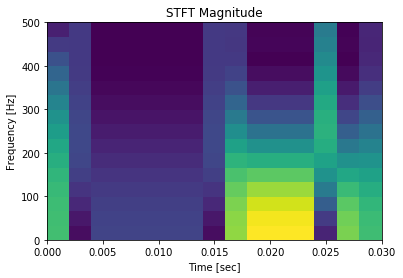

In [233]:
# Make Test Dataset
testdata1 = np.loadtxt("EMG_data_for_gestures-master/02/1_raw_data_14-19_22.03.16.txt", skiprows=1)
testdata2 = np.loadtxt("EMG_data_for_gestures-master/02/2_raw_data_14-21_22.03.16.txt", skiprows=1)
testdata = np.concatenate((testdata1, testdata2), axis=0)
X_test = testdata[:, 1:9]
print(testdata.shape)
X_test = X_test - np.mean(X_test, axis=0)
X_test = X_test / np.linalg.norm(X_test, axis=0)

# I mean subtracted and normalized so we don't have to worry about bias 
# and differences in amplitude between channels and recordings
y_test = testdata[:, -1]
m1 = X_test[np.where(y_test == 1), :]
print("Number of samples in class 1: ", m1.shape[1])
m2 = X_test[np.where(y_test == 2), :]
print("Number of samples in class 2: ", m2.shape[1])
m3 = X_test[np.where(y_test == 3), :]
print("Number of samples in class 3: ", m3.shape[1])
m4 = X_test[np.where(y_test == 4), :]
print("Number of samples in class 4: ", m4.shape[1])
m5 = X_test[np.where(y_test == 5), :]
print("Number of samples in class 5: ", m5.shape[1])
m6 = X_test[np.where(y_test == 6), :]
print("Number of samples in class 6: ", m6.shape[1])

# Sampling rate
fs = 1000
# Define the window length of data we are selecting
window_length = 30
# I'm going to extract overlapping blocks and I will increment by step 
step = 5

# iterate over the gestures
all_time_data = []
time_lengths = []
y_time = []
for idx, gesture in enumerate([m1, m2, m3, m4, m5, m6]):
    gesture = np.squeeze(gesture)
    # Define the time length since each gesture has a different number of time samples
    time_length = gesture.shape[0]
    time_lengths.append(time_length)
    # Find the number of windows we will take given our window length and step
    num_data = math.floor((time_length - window_length) / step)
    # Now extract the windows
    time_data = np.zeros((num_data, window_length, 8))
    for n in range(num_data):
        time_data[n, :, :] = gesture[n*step:n*step+window_length, :]
        y_time.append(idx+1)
    all_time_data.append(time_data)

# Done with time domain data
X_time_test = np.concatenate((all_time_data[0], all_time_data[1], all_time_data[2], all_time_data[3], all_time_data[4], all_time_data[5]), axis=0)
y_time_test = np.array(y_time) - 1
print(X_time_test.shape)
print(y_time_test.shape)

# Did some tuning of the size of the stft
f, t, Zxx = signal.stft(X_time_test[50, :, 0], fs, nperseg=5, noverlap=3, nfft=30)
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()   

# Generate stft data from time data
X_stft_test = np.zeros((X_time_test.shape[0], 16, 16, 8))
for i in range(X_time_test.shape[0]):
    for j in range(X_time_test.shape[2]):
        f, t, Zxx = signal.stft(X_time_test[i, :, j], fs, nperseg=5, noverlap=3, nfft=30)
        X_stft_test[i, :, :, j] = np.asarray(np.abs(Zxx))

# One hot encoding of the labels to be compatible with NN
y_stft_test = copy.deepcopy(y_time_test)
# y_stft_test = np.zeros((X_stft_test.shape[0], 6))
# for i in range(X_stft_test.shape[0]):
#     y_stft_test[i, y_time_test-1] = 1

In [267]:
# Now that we have the processed data we can build the CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
batch_size = 32

# I'm using 3 conv layers and 3 FC layers
# Just using a simple Lenet 5 type structure
# Added batch normalization and dropout to improve training and test error
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.batch = batch_size
        self.c1 = nn.Conv2d(8, 64, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.c3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256*16, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 6)
        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.AvgPool2d(2, stride = 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        
    def forward(self, x):       
        # add hidden layer, with relu activation function
        x = F.relu(self.bn1(self.c1(x)))
        x = self.maxpool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.bn2(self.c2(x)))
        x = self.maxpool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.bn3(self.c3(x)))
        # add output layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [268]:
def train_model(model, batch_size, n_epochs, criterion, optimizer):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []

    
    for epoch in range(1, n_epochs + 1):
        model = model.float()
        model.train() # prep model for training
        for batch, (data, target) in enumerate(trainloader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.long())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
        

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        avg_train_losses.append(train_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []

        
    return  model, avg_train_losses

In [269]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Set the number of epochs to train
n_epochs = 25
transform = transforms.ToTensor()

# Need to define the Dataset since its a custom made one
class EMGDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i, :, :, :]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = EMGDataset(X_stft_train, y_stft_train, transforms=transform)
test_data = EMGDataset(X_stft_test, y_stft_test, transforms=transform)
# dataloaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)        
       
# initialize the NN
model = ConvNet()
print(model)

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train model
model, train_loss = train_model(model, batch_size, n_epochs, criterion, optimizer)

ConvNet(
  (c1): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
[ 1/25] train_loss: 0.52885 
[ 2/25] train_loss: 0.35542 
[ 3/25] train_loss: 0.30292 
[ 4/25] train_loss: 0.27137 
[ 5/25] train_loss: 0.25157 
[ 6/25] train_loss: 0.23907 
[ 7/25] train_loss: 0.21658 
[ 8/25

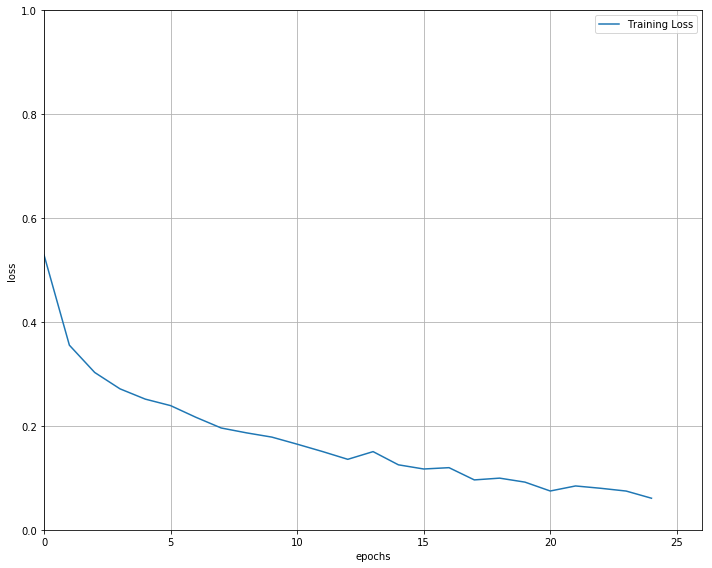

In [270]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [271]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for evaluation

for data, target in testloader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of Class %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of Class %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.974540

Test Accuracy of Class     0: 96% (1365/1420)
Test Accuracy of Class     1: 100% (1343/1343)
Test Accuracy of Class     2: 99% (1342/1346)
Test Accuracy of Class     3: 66% (906/1354)
Test Accuracy of Class     4: 88% (1203/1360)
Test Accuracy of Class     5: 65% (961/1465)

Test Accuracy (Overall): 85% (7120/8288)


In [272]:
# Now that we have the processed data we can build the CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
batch_size = 32

# I'm using 3 conv layers and 3 FC layers
# Just using a simple Lenet 5 type structure
# Added batch normalization and dropout to improve training and test error
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.batch = batch_size
        self.c1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.c3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256*14, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 6)
        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.AvgPool2d(2, stride = 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        
    def forward(self, x):       
        # add hidden layer, with relu activation function
        x = F.relu(self.bn1(self.c1(x)))
        x = self.maxpool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.bn2(self.c2(x)))
        x = self.maxpool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.bn3(self.c3(x)))
        # add output layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [273]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Set the number of epochs to train
n_epochs = 25
transform = transforms.ToTensor()

# Need to define the Dataset since its a custom made one
class EMGDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i, :, :, :]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = EMGDataset(np.expand_dims(X_time_train, axis=3), y_time_train, transforms=transform)
test_data = EMGDataset(np.expand_dims(X_time_test, axis=3), y_time_test, transforms=transform)
# dataloaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)        
       
# initialize the NN
model = ConvNet()
print(model)

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train model
model, train_loss = train_model(model, batch_size, n_epochs, criterion, optimizer)

ConvNet(
  (c1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3584, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
[ 1/25] train_loss: 0.65110 
[ 2/25] train_loss: 0.34133 
[ 3/25] train_loss: 0.28243 
[ 4/25] train_loss: 0.22989 
[ 5/25] train_loss: 0.20918 
[ 6/25] train_loss: 0.18624 
[ 7/25] train_loss: 0.16801 
[ 8/25

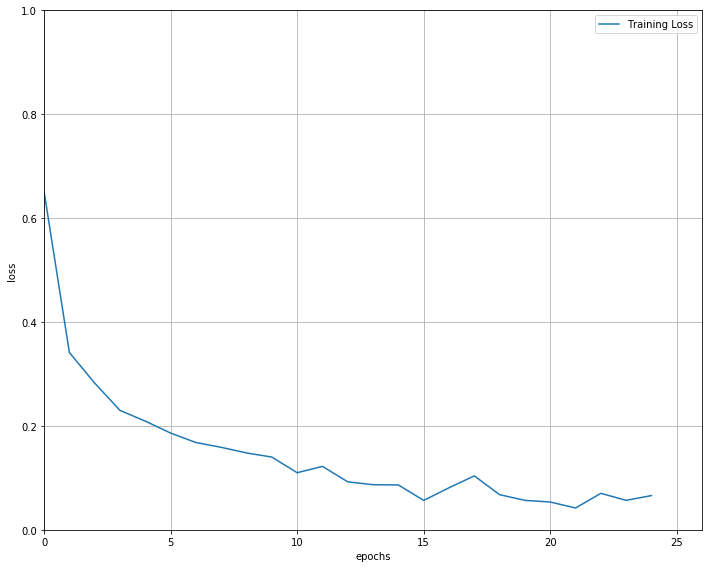

In [274]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [275]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for evaluation

for data, target in testloader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of Class %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of Class %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 47.695938

Test Accuracy of Class     0:  0% ( 0/1415)
Test Accuracy of Class     1:  3% (53/1345)
Test Accuracy of Class     2: 15% (212/1352)
Test Accuracy of Class     3:  0% ( 0/1351)
Test Accuracy of Class     4: 100% (1362/1362)
Test Accuracy of Class     5:  3% (50/1463)

Test Accuracy (Overall): 20% (1677/8288)


In [ ]:
# We see that the CNN with the time series data performed better than the logistic model
# but still quite poorly.
# However, the CNN with the spectrogram data got 85% accurracy. 
# This is quite good considering we only used one subject worth of training data.
# If I wanted to improve this model I would expand the training set with the other subjects.